<a href="https://colab.research.google.com/github/Aditi01-git/ML-Projects/blob/main/Movie_Recommender_System_using_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

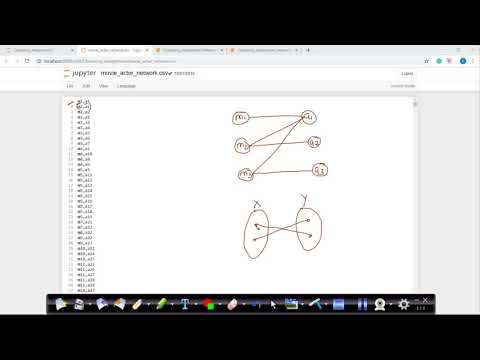

In [ ]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='_XJlZtZqMUs', width=600)

In [ ]:
import stellargraph

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving movie_actor_network.csv to movie_actor_network (3).csv


In [ ]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])     

In [ ]:
edges = [tuple(x) for x in data.values.tolist()]

In [ ]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [ ]:
#A = list(nx.connected_component_subgraphs(B))[0]
A = [B.subgraph(c).copy() for c in nx.connected_components(B)]

In [ ]:
print("number of nodes", A[0].number_of_nodes())
print("number of edges", A[0].number_of_edges())

number of nodes 4703
number of edges 9650


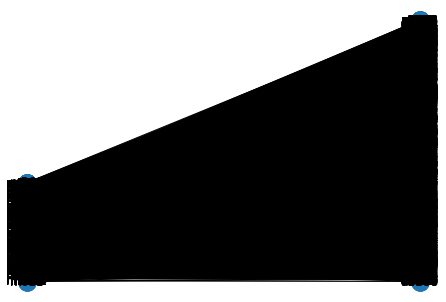

In [ ]:
l, r = nx.bipartite.sets(A[0])
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A[0], pos=pos, with_labels=True)
plt.show()

In [ ]:
movies = []
actors = []
for i in A[0].nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [ ]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A[0]))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A[0].nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [ ]:
print(type(walks))

<class 'list'>


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [ ]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A[0].nodes[node_id]['label'] for node_id in node_ids]

In [ ]:
node_embeddings

array([[ 6.1610907e-01, -5.6438923e-01,  3.4024805e-01, ...,
        -7.5985086e-01, -1.4219760e+00,  2.3040864e+00],
       [-7.9495794e-01, -7.8637671e-01,  8.2486767e-01, ...,
        -6.2361002e-01,  3.2727852e-01,  1.6834500e+00],
       [ 1.0574597e-01, -9.4668025e-01,  4.1985029e-01, ...,
        -6.8145287e-01, -7.9591250e-01,  1.7489902e+00],
       ...,
       [-4.1785691e-02, -2.6581461e-02, -1.1318700e-02, ...,
         5.1191289e-02,  3.1603552e-02,  5.3459320e-02],
       [-5.9506111e-03, -5.3220000e-02, -9.2223827e-03, ...,
         3.4205593e-02,  2.2820407e-03,  7.2075583e-02],
       [ 5.8458894e-02, -3.9771736e-02, -2.6024576e-02, ...,
         7.1924441e-02,  5.3200841e-02,  1.3530266e-02]], dtype=float32)

In [ ]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

In [ ]:
node_embeddings_2d.shape

(4703, 2)

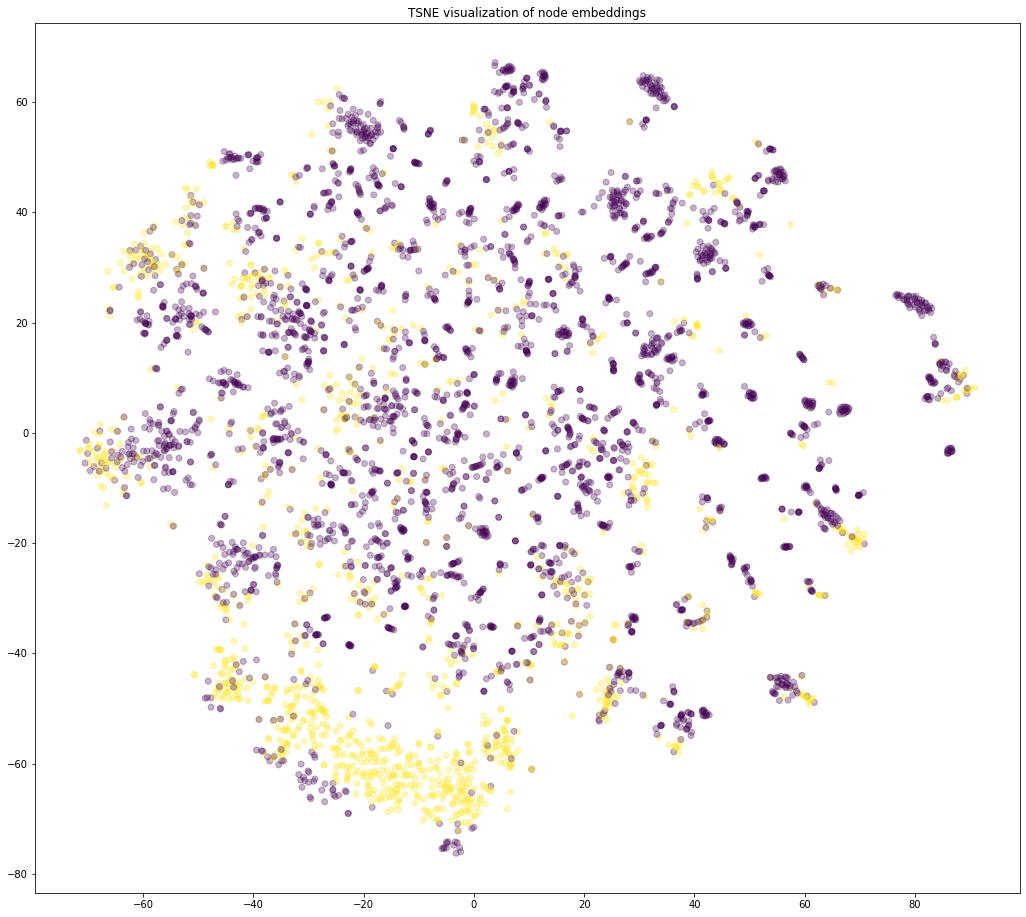

In [ ]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

In [ ]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    for i in range(len(node_targets)):
      if node_targets[i] == 'movie':
        movie_embeddings.append(node_embeddings[i])
      elif node_targets[i] == 'actor':
        actor_embeddings.append(node_embeddings[i])
    
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for j in range(len(node_targets)):
      if node_targets[j] == 'movie':
        movie_nodes.append(node_ids[j])
      elif node_targets[j] == 'actor':
        actor_nodes.append(node_ids[j])
    
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

In [ ]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Graded function - 1</font>

In [ ]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Graded function - 2</font>

In [ ]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

### Apply Clustering on actor_nodes


In [ ]:
actor_data = np.asarray(actor_embeddings)
actor_data.shape

(3411, 128)

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [ ]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    term = 0 
    cost1 = 0
    for i in range(number_of_clusters):
      hublist = []
      largest_hub = 0
      result=0
      total_nodes = 0
      total_nodes = graph[i].number_of_nodes()
      hublist = sorted(nx.connected_components(graph[i]), key = len, reverse=True)
      largest_hub = len(hublist[0])
      result = largest_hub/total_nodes
      term = term + result
    cost1 = term / number_of_clusters
    
    return cost1

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [ ]:
def cost2(graph,number_of_clusters,id):
    '''In this function, we will calculate cost2'''
    cost2 = 0
    term = 0
    for j in range(number_of_clusters):
      deno = []
      unique_deno=0
      degree_sum=0
      result = 0
      if id == 1:
        for i in graph[j].nodes():
          if 'm' in i:
            deno.append(i)
        unique_deno = len(deno)
      elif id == 2:
        for i in graph[j].nodes():
          if 'a' in i:
            deno.append(i)
        unique_deno = len(deno)
      degree_sum = graph[j].number_of_edges()
      result = degree_sum/ unique_deno
      term = term + result
    cost2 = term / number_of_clusters
    
    return cost2

In [ ]:
from tqdm import tqdm

In [ ]:
def clustering_metric(col_nodes,col_data,node_identity):
  cluster_select = [3,5,10,30,50,100,200,500]
  costlist = []
  for number_of_clusters in tqdm(cluster_select):
    #Creating a list for adding ego graphs of each cluster
    cluster_graph = []
    #Applying K_Means Algo
    kmeans = KMeans(n_clusters=number_of_clusters)
    kmeans.fit(col_data)
    cluster_labels = kmeans.labels_
    #To get unique values of clusters
    uniq_clus = list(set(cluster_labels))
    for u in range(len(uniq_clus)):
      #This list contains actor nodes of each cluster
      subgraph_actors = []
      for c in range(len(cluster_labels)):
        if uniq_clus[u] == cluster_labels[c]:
          subgraph_actors.append(col_nodes[c])
      # G will be ego graph corresponding to each cluster
      G = nx.Graph()
      for r in range(len(subgraph_actors)):
        #sub_graph is to create ego graph
        sub_graph=nx.ego_graph(B,subgraph_actors[r])
        #Merging graphs
        if G.size() == 0:
          G.add_edges_from(sub_graph.edges(data = True))
          G.add_nodes_from(sub_graph.nodes(data = True))
        else:
          G.add_edges_from(list(sub_graph.edges(data = True)) + list(G.edges(data = True)))
          G.add_nodes_from(list(sub_graph.nodes(data = True)) + list(G.nodes(data = True)))
      #Append ego-graph of each cluster to cluster_graph list
      cluster_graph.append(G)
    
    #compute cost1,cost2 of each cluster graph
    c1 = cost1(cluster_graph,number_of_clusters)
    c2 = cost2(cluster_graph,number_of_clusters,node_identity) 
    #computer the metric Cost = Cost1*Cost2
    metric = c1*c2
    costlist.append(metric)

  cost_dict = (dict(zip(cluster_select,costlist)))
  return(max(cost_dict.items(), key=lambda x : x[1])[0])

In [ ]:
no_of_clusters_actor = clustering_metric(actor_nodes,actor_data,1)

100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


In [ ]:
print(no_of_clusters_actor)

3


<font color='blue'>Grouping similar actors</font>

In [ ]:
kMeans_actor = KMeans(n_clusters=no_of_clusters_actor)
kMeans_actor.fit(actor_data)
actor_labels = kMeans_actor.labels_

In [ ]:
actor_labels.shape

(3411,)

In [ ]:
transform = TSNE #PCA

trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

In [ ]:
(actor_embeddings_2d).shape

(3411, 2)

<font color='blue'>Displaying similar actor clusters</font>

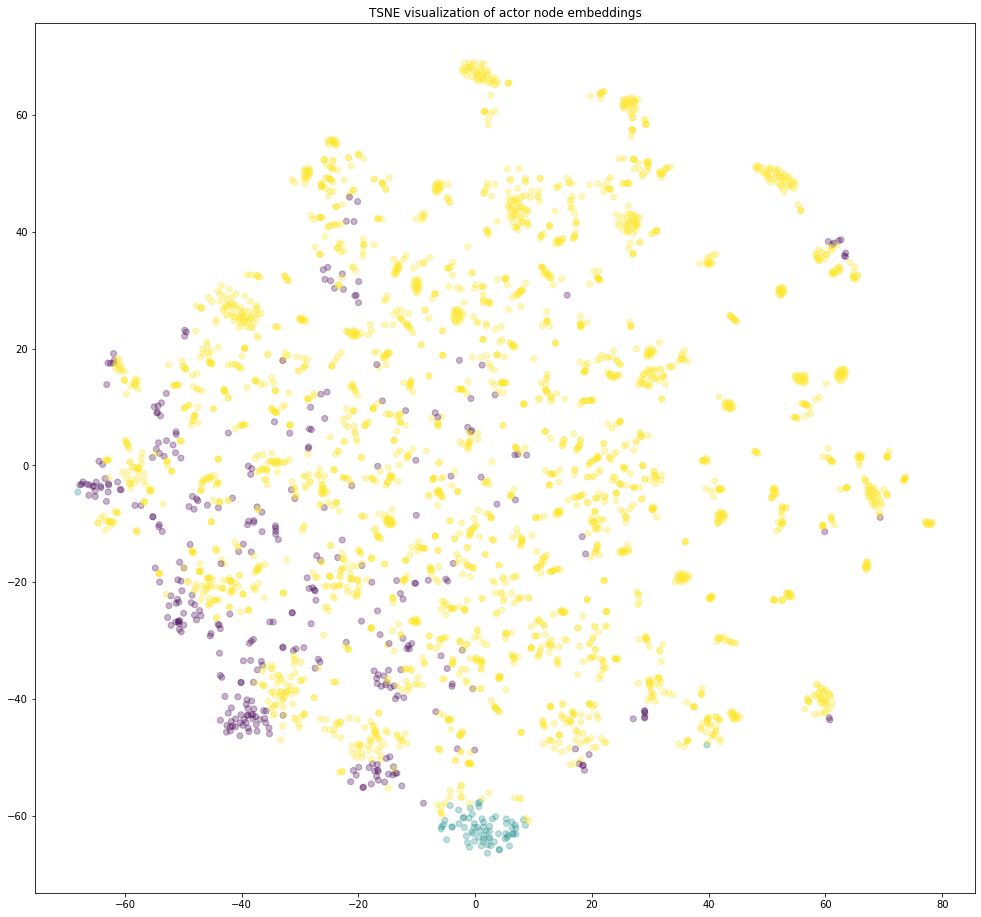

In [ ]:
label_map = { l: i for i, l in enumerate(np.unique(actor_labels))}
node_colours = [ label_map[target] for target in actor_labels]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(actor_embeddings_2d[:,0], 
            actor_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of actor node embeddings'.format(transform.__name__))

plt.show()

## Apply clustering to movie nodes


In [ ]:
movie_data = np.asarray(movie_embeddings)

In [ ]:
no_of_clusters_movie = clustering_metric(movie_nodes,movie_data,2)

100%|██████████| 8/8 [00:45<00:00,  5.66s/it]


In [ ]:
print(no_of_clusters_movie)

3


<font color='blue'>Grouping similar movies</font>

In [ ]:
kMeans_movie = KMeans(n_clusters=no_of_clusters_movie)
kMeans_movie.fit(movie_data)
movie_labels = kMeans_movie.labels_

In [ ]:
movie_labels.shape

(1292,)

In [ ]:
transform = TSNE #PCA

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

In [ ]:
(movie_embeddings_2d).shape

(1292, 2)

<font color='blue'>Displaying similar movie clusters</font>

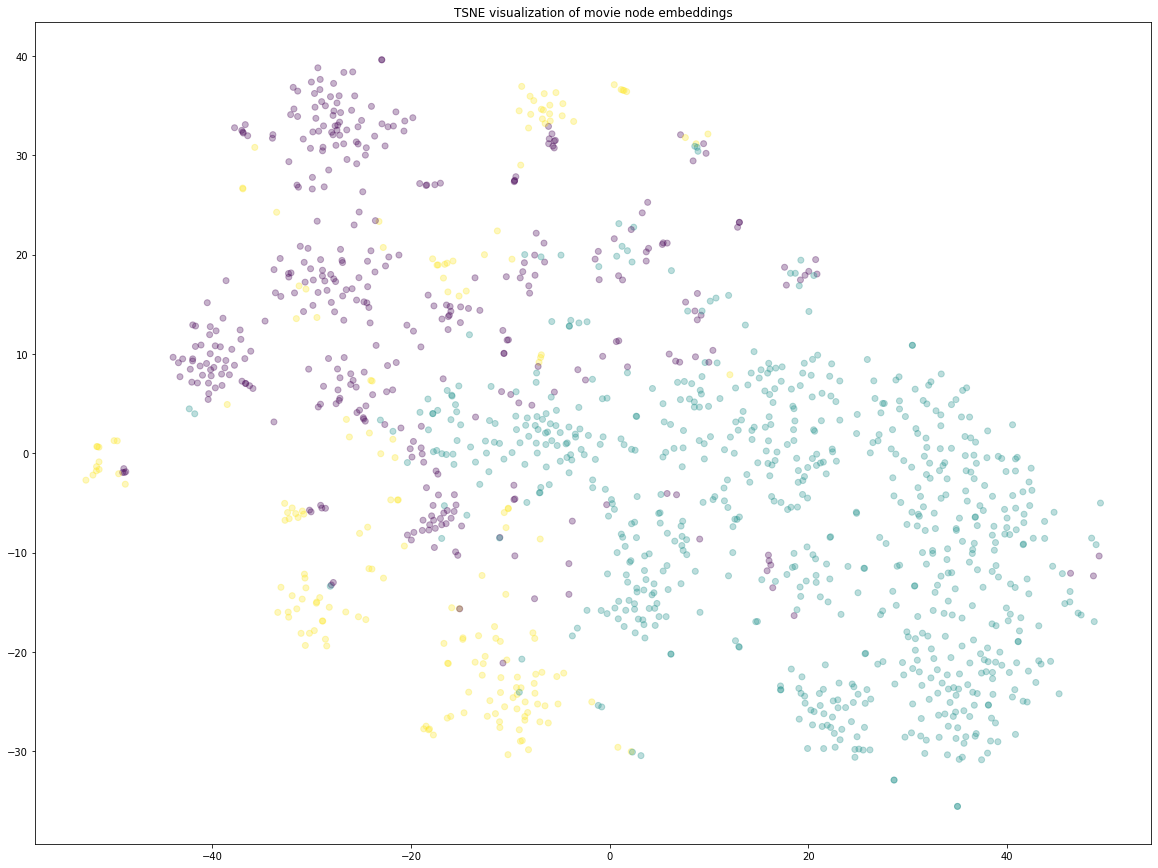

In [ ]:
label_map = { l: i for i, l in enumerate(np.unique(movie_labels))}
node_colours = [ label_map[target] for target in movie_labels]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(movie_embeddings_2d[:,0], 
            movie_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of movie node embeddings'.format(transform.__name__))

plt.show()